In [50]:
import pandas as pd
import numpy as np
import string
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import pandas as pd
import rew
import string
import nltk
from nltk.stem import PorterStemmer

from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from tensorflow.keras.utils import pad_sequences
import numpy as np
from sklearn.metrics import confusion_matrix
nltk.download("stopwords")
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

from keras.models import Sequential
from keras.layers import Dense,Embedding, LSTM, Dropout
from keras.layers import Dense, BatchNormalization, Embedding, LSTM
import keras
from keras import callbacks
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /home/pavel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# https://www.kaggle.com/datasets/anjaneyatripathi/emotion-classification-nlp/data

In [3]:
dataframe_train = pd.read_csv("dataset/emotion-labels-train.csv")
dataframe_test = pd.read_csv("dataset/emotion-labels-test.csv")
dataframe_validation = pd.read_csv("dataset/emotion-labels-val.csv")

In [4]:
processing_dataframe = pd.concat([dataframe_train, dataframe_test], axis=0)
processing_dataframe = processing_dataframe.sample(frac=1).reset_index(drop=True)

In [5]:
processing_dataframe.text.str.isspace().sum()

0

In [6]:
processing_dataframe.isnull().sum()

text     0
label    0
dtype: int64

In [7]:
processing_dataframe.text.str.isspace().sum()

0

In [8]:
processing_dataframe.head()

,text,label
0,Don King...his actions really sadden me today....,sadness
1,The new gun emoji in iOS10 is not enough to sh...,anger
2,@KWAYNTjoia it's exhilarating,joy
3,@OstinOng YUUUHH 🙄😭 plus clin ep and prevmed u...,anger
4,Why can't you just be mine. #forlorn,sadness


In [9]:
def clean_string(text, stem="None"):
    final_string = ""
    text = text.lower()

    text = re.sub(r'\n', '', text)

    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['hi', 'im']

    text_filtered = [word for word in text if not word in useless_words]

    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string

In [10]:
processing_dataframe['clean_text'] = processing_dataframe['text'].apply(lambda x: clean_string(x, "Stem"))
processing_dataframe.head()

,text,label,clean_text
0,Don King...his actions really sadden me today....,sadness,kinghi action realli sadden todayth word may p...
1,The new gun emoji in iOS10 is not enough to sh...,anger,new gun emoji enough show anger toward number...
2,@KWAYNTjoia it's exhilarating,joy,kwayntjoia exhilar
3,@OstinOng YUUUHH 🙄😭 plus clin ep and prevmed u...,anger,ostinong yuuuhh 🙄😭 plu clin ep prevm ugghhh ha...
4,Why can't you just be mine. #forlorn,sadness,cant mine forlorn


In [11]:
processing_dataframe['text_len'] = processing_dataframe['clean_text'].apply(len)
processing_dataframe.head()

,text,label,clean_text,text_len
0,Don King...his actions really sadden me today....,sadness,kinghi action realli sadden todayth word may p...,67
1,The new gun emoji in iOS10 is not enough to sh...,anger,new gun emoji enough show anger toward number...,52
2,@KWAYNTjoia it's exhilarating,joy,kwayntjoia exhilar,18
3,@OstinOng YUUUHH 🙄😭 plus clin ep and prevmed u...,anger,ostinong yuuuhh 🙄😭 plu clin ep prevm ugghhh ha...,57
4,Why can't you just be mine. #forlorn,sadness,cant mine forlorn,17


[Text(0.5, 0, 'Klasy'),
 Text(0, 0.5, 'Ilość'),
 Text(0.5, 1.0, 'Rozkład ilości poszczególnych klas')]

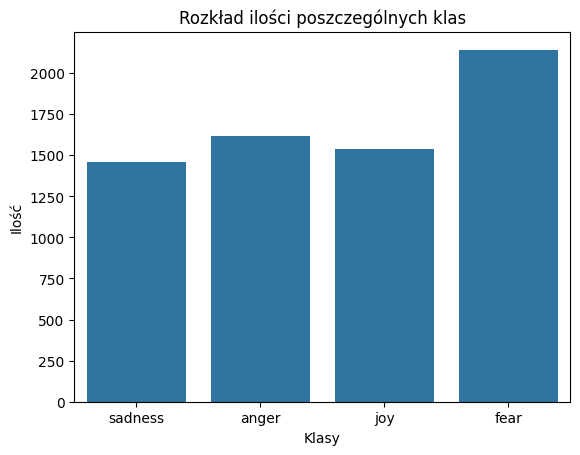

In [12]:
ax = sns.countplot(processing_dataframe, x='label')
ax.set(xlabel='Klasy', ylabel='Ilość', title='Rozkład ilości poszczególnych klas')


In [13]:
processing_dataframe.label.value_counts()

label
fear       2142
anger      1617
joy        1537
sadness    1459
Name: count, dtype: int64

[Text(0.5, 1.0, 'Klasa - Joy'),
 Text(0.5, 0, 'Liczba słów'),
 Text(0, 0.5, 'Gęstość')]

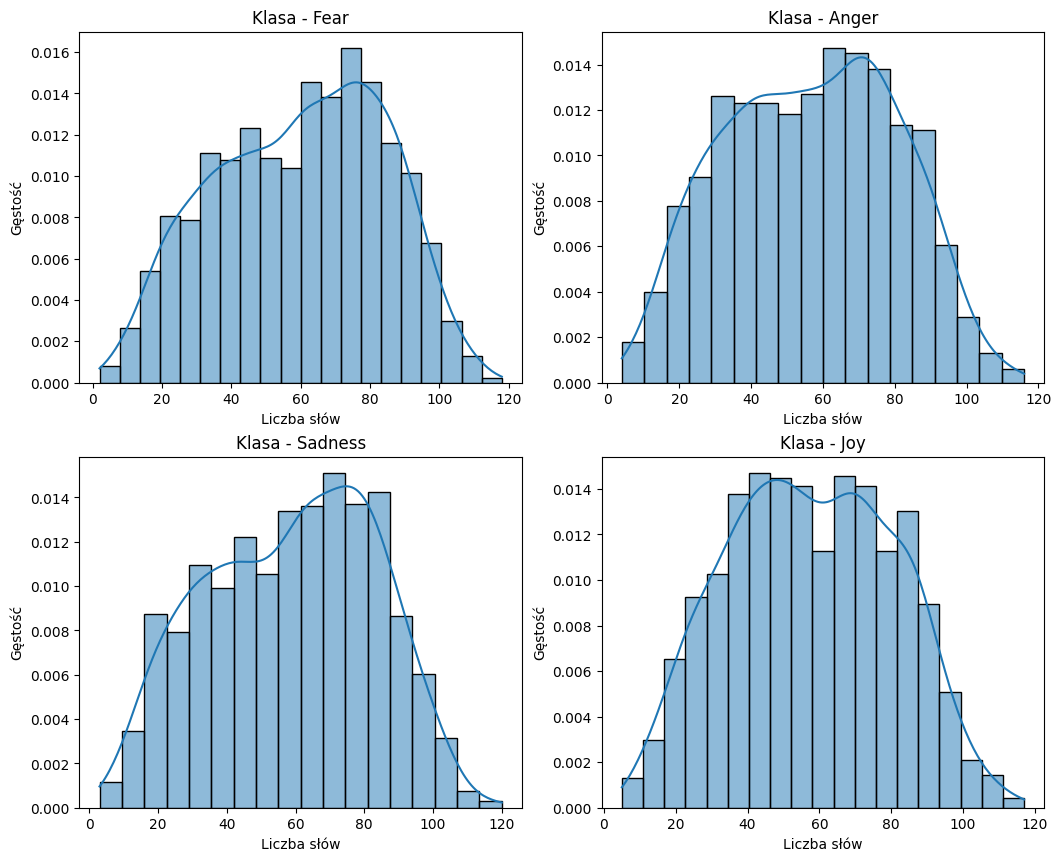

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10.5, 8.5), layout="constrained")

sns.histplot(processing_dataframe[processing_dataframe['label'] == "fear"].text_len, ax=axs[0,0], kde=True, stat='density').set(title='Klasa - Fear', xlabel='Liczba słów', ylabel='Gęstość')
sns.histplot(processing_dataframe[processing_dataframe['label'] == "anger"].text_len, ax=axs[0,1], kde=True, stat='density').set(title='Klasa - Anger', xlabel='Liczba słów', ylabel='Gęstość')
sns.histplot(processing_dataframe[processing_dataframe['label'] == "sadness"].text_len, ax=axs[1,0], kde=True, stat='density').set(title='Klasa - Sadness', xlabel='Liczba słów', ylabel='Gęstość')
sns.histplot(processing_dataframe[processing_dataframe['label'] == "joy"].text_len, ax=axs[1,1], kde=True, stat='density').set(title='Klasa - Joy', xlabel='Liczba słów', ylabel='Gęstość')


(-0.5, 399.5, 199.5, -0.5)

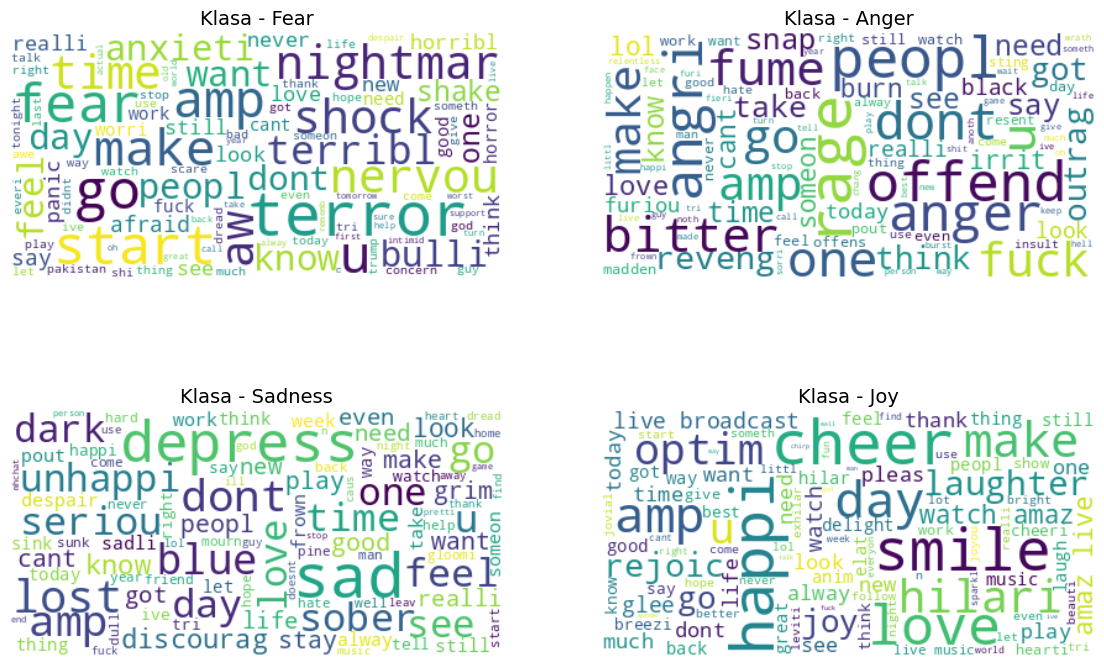

In [15]:
fig, axs = plt.subplots(2, 2, figsize  = (14,9))

wordcloud_joy = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(processing_dataframe[processing_dataframe['label'] == "joy"].clean_text))
wordcloud_sadness = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(processing_dataframe[processing_dataframe['label'] == "sadness"].clean_text))
wordcloud_anger = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(processing_dataframe[processing_dataframe['label'] == "anger"].clean_text))
wordcloud_fear = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(processing_dataframe[processing_dataframe['label'] == "fear"].clean_text))

axs[0,0].imshow(wordcloud_fear, interpolation='bilinear')
axs[0,0].set_title('Klasa - Fear', fontsize=14)
axs[0,0].axis('off')
axs[1,1].imshow(wordcloud_joy, interpolation='bilinear')
axs[1,1].set_title('Klasa - Joy', fontsize=14)
axs[1,1].axis('off')
axs[1,0].imshow(wordcloud_sadness, interpolation='bilinear')
axs[1,0].set_title('Klasa - Sadness', fontsize=14)
axs[1,0].axis('off')
axs[0,1].imshow(wordcloud_anger, interpolation='bilinear')
axs[0,1].set_title('Klasa - Anger', fontsize=14)
axs[0,1].axis('off')


In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(processing_dataframe['label'])
processing_dataframe['label_encoded'] = le.transform(processing_dataframe['label'])
integer_mapping = {l: i for i, l in enumerate(le.classes_)}

processing_dataframe.head()

,text,label,clean_text,text_len,label_encoded
0,Don King...his actions really sadden me today....,sadness,kinghi action realli sadden todayth word may p...,67,3
1,The new gun emoji in iOS10 is not enough to sh...,anger,new gun emoji enough show anger toward number...,52,0
2,@KWAYNTjoia it's exhilarating,joy,kwayntjoia exhilar,18,2
3,@OstinOng YUUUHH 🙄😭 plus clin ep and prevmed u...,anger,ostinong yuuuhh 🙄😭 plu clin ep prevm ugghhh ha...,57,0
4,Why can't you just be mine. #forlorn,sadness,cant mine forlorn,17,3


In [17]:
def calculate_most_common_word_by_label(df, label: str, len_words: int = 10):
    words = df[df.label==label].clean_text.apply(lambda x: [word.lower() for word in x.split()])
    ham_words = Counter()
    for msg in words:
        ham_words.update(msg)
        
    return ham_words.most_common(len_words)

In [18]:
calculate_most_common_word_by_label(processing_dataframe, "fear", 10)

[('terror', 155),
 ('like', 143),
 ('go', 131),
 ('get', 130),
 ('dont', 127),
 ('fear', 121),
 ('start', 108),
 ('amp', 98),
 ('make', 91),
 ('know', 88)]

In [19]:
calculate_most_common_word_by_label(processing_dataframe, "anger", 10)

[('like', 127),
 ('get', 120),
 ('rage', 113),
 ('dont', 96),
 ('peopl', 91),
 ('offend', 88),
 ('anger', 84),
 ('angri', 84),
 ('one', 75),
 ('bitter', 73)]

In [20]:
calculate_most_common_word_by_label(processing_dataframe, "sadness", 10)

[('sad', 173),
 ('depress', 154),
 ('get', 119),
 ('dont', 99),
 ('lost', 90),
 ('like', 88),
 ('amp', 82),
 ('blue', 78),
 ('time', 70),
 ('know', 69)]

In [21]:
calculate_most_common_word_by_label(processing_dataframe, "joy", 10)

[('happi', 166),
 ('cheer', 142),
 ('live', 141),
 ('smile', 138),
 ('love', 116),
 ('watch', 109),
 ('make', 99),
 ('day', 95),
 ('amp', 94),
 ('hilari', 78)]

In [22]:
from sklearn.model_selection import train_test_split


In [23]:
processing_dataframe.head()

,text,label,clean_text,text_len,label_encoded
0,Don King...his actions really sadden me today....,sadness,kinghi action realli sadden todayth word may p...,67,3
1,The new gun emoji in iOS10 is not enough to sh...,anger,new gun emoji enough show anger toward number...,52,0
2,@KWAYNTjoia it's exhilarating,joy,kwayntjoia exhilar,18,2
3,@OstinOng YUUUHH 🙄😭 plus clin ep and prevmed u...,anger,ostinong yuuuhh 🙄😭 plu clin ep prevm ugghhh ha...,57,0
4,Why can't you just be mine. #forlorn,sadness,cant mine forlorn,17,3


In [24]:
X = processing_dataframe.clean_text
y = processing_dataframe.label_encoded

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

In [25]:
from keras.preprocessing import text, sequence

In [26]:
tokenizer_length = 512

In [27]:
tokenizer = text.Tokenizer(num_words=tokenizer_length)

tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_sequence_train = pad_sequences(tokenized_train, maxlen=tokenizer_length)
y_train_keras = y_train.values.reshape(len(y_train), 1)


tokenized_test = tokenizer.texts_to_sequences(x_test)
x_sequence_test = pad_sequences(tokenized_test, maxlen=tokenizer_length)

In [28]:
def create_model(tokenizer_length):
    model = Sequential()
    model.add(Embedding(tokenizer_length, 256))
    model.add(LSTM(128, return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(64, return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(12))
    model.add(Dense(4, activation='sigmoid'))
    model.summary()
    model.compile(metrics=['Accuracy'], loss = keras.losses.SparseCategoricalCrossentropy(), optimizer='Adam')
    return model

In [29]:
container_callbacks = [
    callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=10, verbose=1),  
]

In [40]:
def learing_models(tokenizer_length, number_models: int):
    container_models = []
    container_callbacks = [
        callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=10, verbose=1),  
    ]

    for _ in range(number_models):
        model = create_model(tokenizer_length)
        history = model.fit(x_sequence_train, y_train_keras, batch_size=512, epochs=100, callbacks=container_callbacks)
        container_models.append([model, history])

    return container_models

In [41]:
container_models = learing_models(tokenizer_length, 1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 256)         131072    
                                                                 
 lstm_3 (LSTM)               (None, None, 128)         197120    
                                                                 
 batch_normalization_2 (Bat  (None, None, 128)         512       
 chNormalization)                                                
                                                                 
 lstm_4 (LSTM)               (None, None, 64)          49408     
                                                                 
 batch_normalization_3 (Bat  (None, None, 64)          256       
 chNormalization)                                                
                                                                 
 lstm_5 (LSTM)               (None, 12)               

In [42]:
def format_target_classes_for_roc_curve(data_classes: list[int], n_classes: int) -> list[list[int]]:
    output: list[list] = [0] * len(data_classes)

    for idx, label in enumerate(data_classes):
        output[idx] = np.array([0] * n_classes)
        output[idx][label] = 1


    return np.array(output)

In [43]:
def choice_best_model(container_models: list):
    container_result = []
    for model, _ in container_models:
        prob_test_vec = model.predict(x_sequence_test)
        y_test_for_roc = format_target_classes_for_roc_curve(y_test, 4)

        fpr, tpr, _ = roc_curve(y_test_for_roc[::, 0], prob_test_vec[::, 0])
        auc_score = auc(fpr, tpr)
        container_result.append(auc_score)

    max_value = max(container_result)
    max_index = container_result.index(max_value)
    print(container_models)
    return container_models[max_index]

In [44]:
best_model, history = choice_best_model(container_models)

43/43 [==============================] - 2s 44ms/step
[[<keras.src.engine.sequential.Sequential object at 0x7f36a03b66b0>, <keras.src.callbacks.History object at 0x7f372aa23700>]]


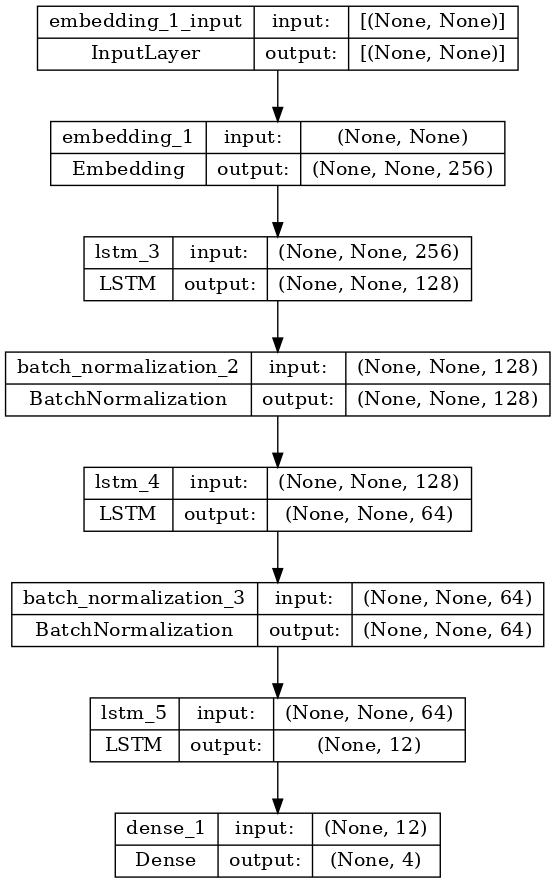

In [45]:
plot_model(best_model,to_file='bert_models.png',dpi=100,show_shapes=True)

43/43 [==============================] - 2s 46ms/step


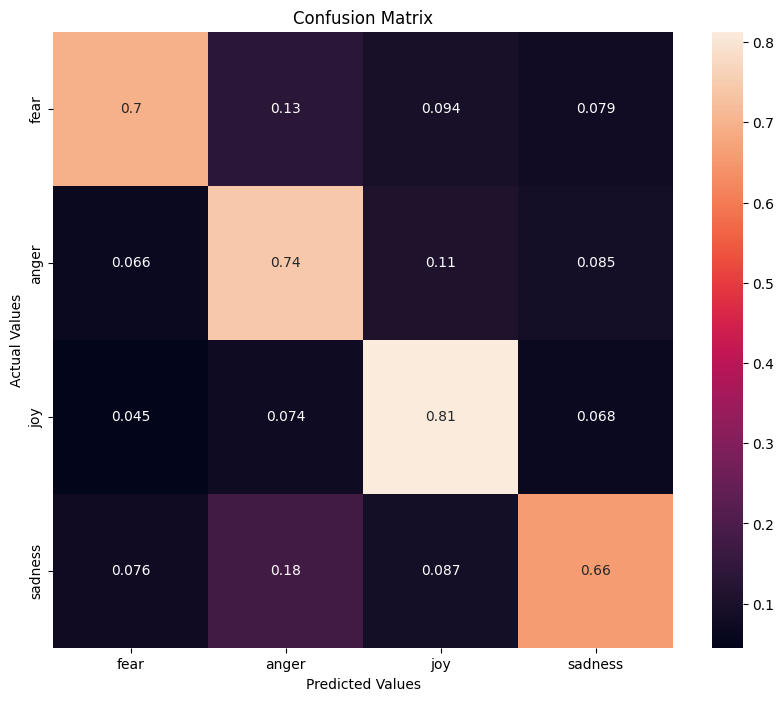

In [46]:
import numpy as np
from sklearn.metrics import confusion_matrix

y_pred=best_model.predict(x_sequence_test)
y_pred=np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred, normalize='true')

cm_df = pd.DataFrame(cm,
                     index = ['fear','anger', 'joy','sadness'], 
                     columns = ['fear','anger', 'joy','sadness'])

plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


In [47]:
cm

array([[0.6969697 , 0.13030303, 0.09393939, 0.07878788],
       [0.06635071, 0.74170616, 0.10663507, 0.08530806],
       [0.04516129, 0.07419355, 0.81290323, 0.06774194],
       [0.07612457, 0.1799308 , 0.08650519, 0.65743945]])

In [48]:
n_classes = 4
fpr = [0] * n_classes
tpr = [0] * n_classes
thresholds = [0] * n_classes
auc_score = [0] * n_classes

def format_target_classes_for_roc_curve(data_classes: list[int], n_classes: int) -> list[list[int]]:
    output: list[list] = [0] * len(data_classes)

    for idx, label in enumerate(data_classes):
        output[idx] = np.array([0] * n_classes)
        output[idx][label] = 1
    
    return np.array(output)


y_pred_proba = best_model.predict(x_sequence_test)
y_test_for_roc = format_target_classes_for_roc_curve(y_test, 5)

for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test_for_roc[::, i],
                                              y_pred_proba[::, i])
    auc_score[i] = auc(fpr[i], tpr[i])

 1/43 [..............................] - ETA: 1s

43/43 [==============================] - 2s 47ms/step


In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74       330
           1       0.73      0.74      0.73       422
           2       0.71      0.81      0.76       310
           3       0.70      0.66      0.68       289

    accuracy                           0.73      1351
   macro avg       0.73      0.73      0.73      1351
weighted avg       0.73      0.73      0.73      1351



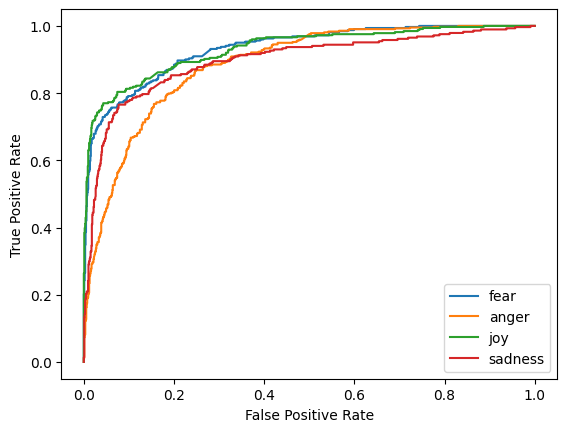

In [ ]:
for i in range(n_classes):
    plt.plot(fpr[i],tpr[i])

plt.legend(['fear','anger', 'joy','sadness'], loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
best_model.save('lstm_model.keras')